In [1]:
import pandas as pd
from fastparquet import ParquetFile
import duckdb
from bs4 import BeautifulSoup
import requests

In [2]:
p1 = ParquetFile("first_half.parquet").to_pandas()

In [64]:
p2 = ParquetFile("second_half.parquet").to_pandas()

In [65]:
p1 = p1.dropna(subset="item").drop(columns=["id"])
p2 = p2.rename(columns={"id" : "item"})
pd.concat([p1,p2]).drop_duplicates().to_parquet("first_half.parquet")

In [12]:
item_df = pd.read_csv("./item_rarities.csv")

In [20]:
item_rarity_map = {
    "Covert": "red",
    "Classified" : "pink",
    "Restricted" : "purple",
    "Mil-spec" : "blue",
    "Industrial": "light-blue",
    "Consumer" : "gray"
}

item_df["Color Rarity"] = item_df["Rarity"].map(item_rarity_map)

In [67]:
graffiti_df = p1[p1["item"].str.contains("Graffiti", na=False)]
graffiti_df.to_parquet("graffiti.parquet")

In [ ]:
sticker_df = p1[p1["item"].str.contains("Sticker", na=False)]

In [3]:
url = "https://raw.githubusercontent.com/ByMykel/CSGO-API/main/public/api/en"


In [5]:
res = requests.get(url + "/stickers.json")
data = res.json()

sticker_data_df = pd.json_normalize(data, sep="_")

want = {
    "id": "id",
    "name": "name",
    "type": "type",
    "effect": "effect",
    "market_hash_name": "market_hash_name",
    "rarity_name": "rarity",
    "rarity_color": "rarity_color",
    "tournament_id": "tournament_id",
    "tournament_name": "tournament",
    "team_id": "team_id",
    "team_tag": "team_tag",
    "team_name": "team",
    "image": "image_url",
}

out = (sticker_data_df.rename(columns=want).reindex(columns=want.values(), fill_value=pd.NA))

out = out.drop(columns=["id"]).rename(columns={"name": "item"})
duckdb.query("SELECT DISTINCT rarity_color FROM out")

┌──────────────┐
│ rarity_color │
│   varchar    │
├──────────────┤
│ #8847ff      │
│ #ded6cc      │
│ #eb4b4b      │
│ #e4ae39      │
│ #d32ce6      │
│ #4b69ff      │
└──────────────┘

In [ ]:
sticker_color_map = {
    "#e4ae39": "gold",
    "#eb4b4b" : "red",
    "#8847ff" : "purple",
    "#d32ce6" : "pink",
    "#4b69ff" : "blue",
    "#ded6cc" : "gray"
}


out["color"] = out["rarity_color"].map(sticker_color_map)
out = out.drop(columns=["rarity_color"])
out = out.rename(columns={"color": "rarity_color"}).copy()

In [10]:
out.head()

,item,type,effect,market_hash_name,rarity,rarity_color,tournament_id,tournament,team_id,team_tag,team,image_url,color
0,Sticker | Shooter,Event,Other,None,Default,#ded6cc,1.0,2013 DreamHack Winter,NaN,NaN,NaN,https://cdn.steamstatic.com/apps/730/icons/eco...,gray
1,Sticker | Shooter (Foil),Event,Foil,None,Default,#ded6cc,1.0,2013 DreamHack Winter,NaN,NaN,NaN,https://cdn.steamstatic.com/apps/730/icons/eco...,gray
2,Sticker | Shooter Close,Event,Other,None,Default,#ded6cc,1.0,2013 DreamHack Winter,NaN,NaN,NaN,https://cdn.steamstatic.com/apps/730/icons/eco...,gray
3,Sticker | Shooter Close (Foil),Event,Foil,None,Default,#ded6cc,1.0,2013 DreamHack Winter,NaN,NaN,NaN,https://cdn.steamstatic.com/apps/730/icons/eco...,gray
4,Sticker | Blue Snowflake,Event,Other,None,Default,#ded6cc,1.0,2013 DreamHack Winter,NaN,NaN,NaN,https://cdn.steamstatic.com/apps/730/icons/eco...,gray


In [6]:
stkr = ParquetFile("sticker.parquet").to_pandas()

<Axes: xlabel='date'>

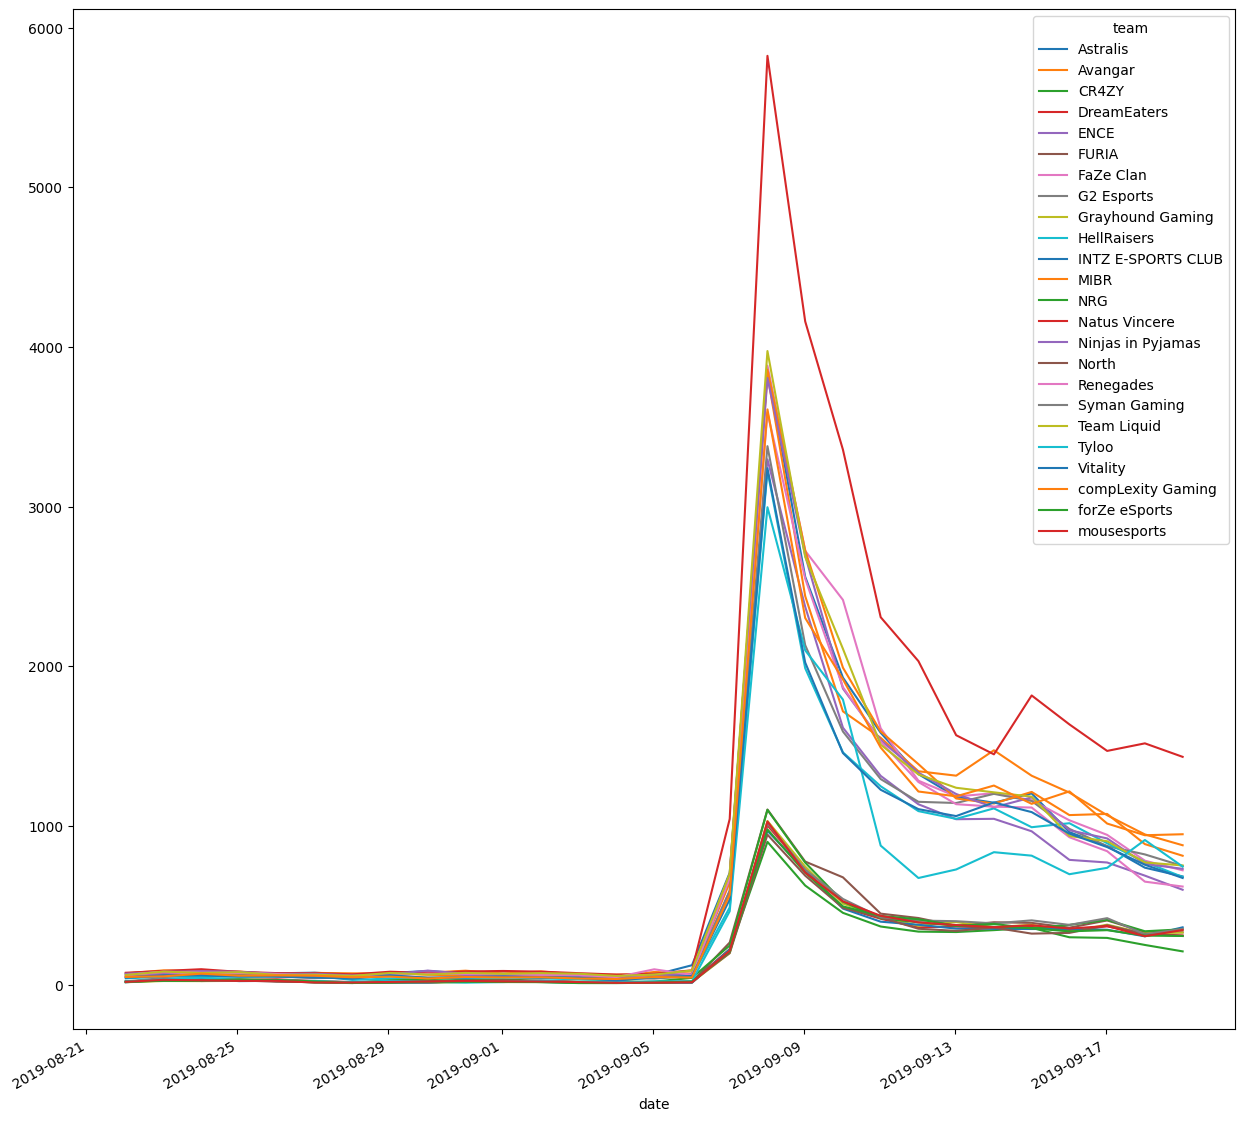

In [68]:
duckdb.query("select team, volume as money, date from stkr where tournament_id = 16 and ABS(DATEDIFF('day', '2019-09-05',date)) < 15").df().pivot_table(columns="team", values="money", index="date").dropna().reset_index().plot.line(
    x="date",
    figsize=(15,15)
)



C:\Users\curti\miniconda3\envs\MarketReview\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


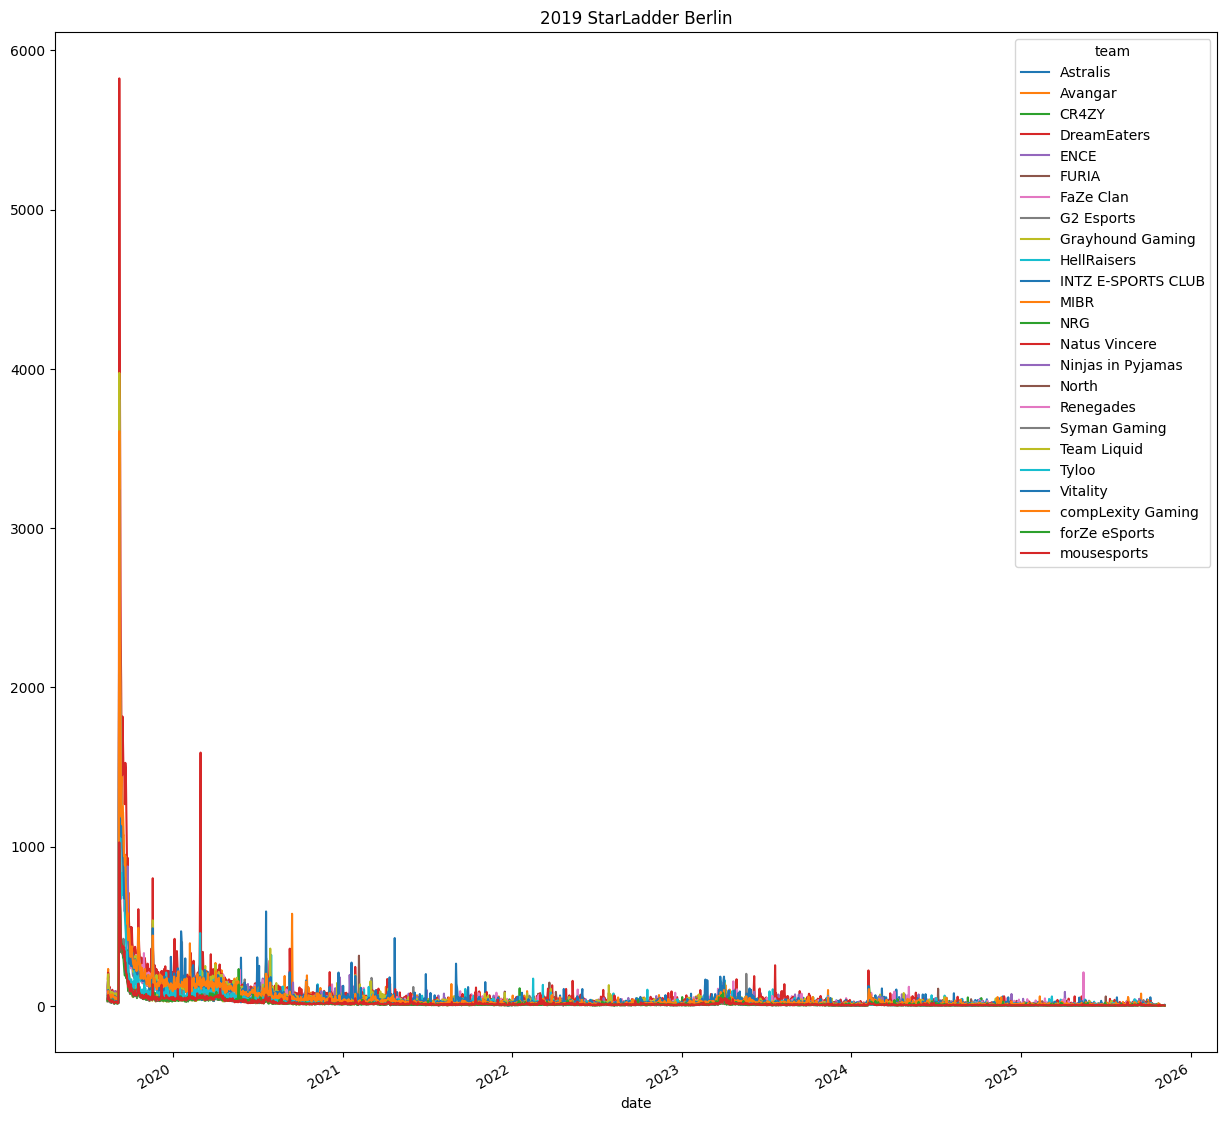

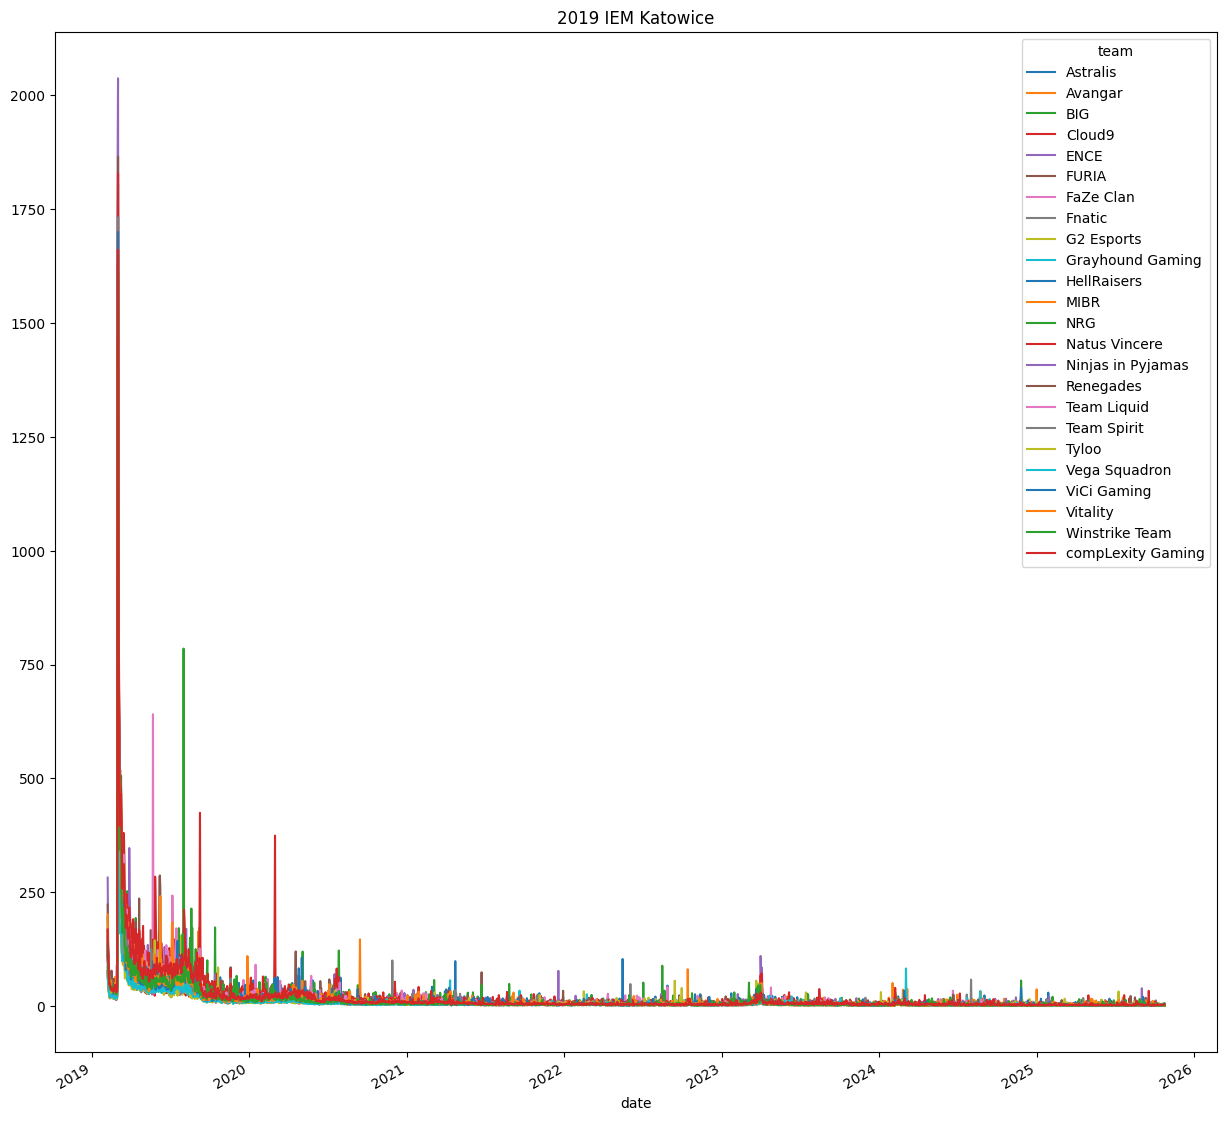

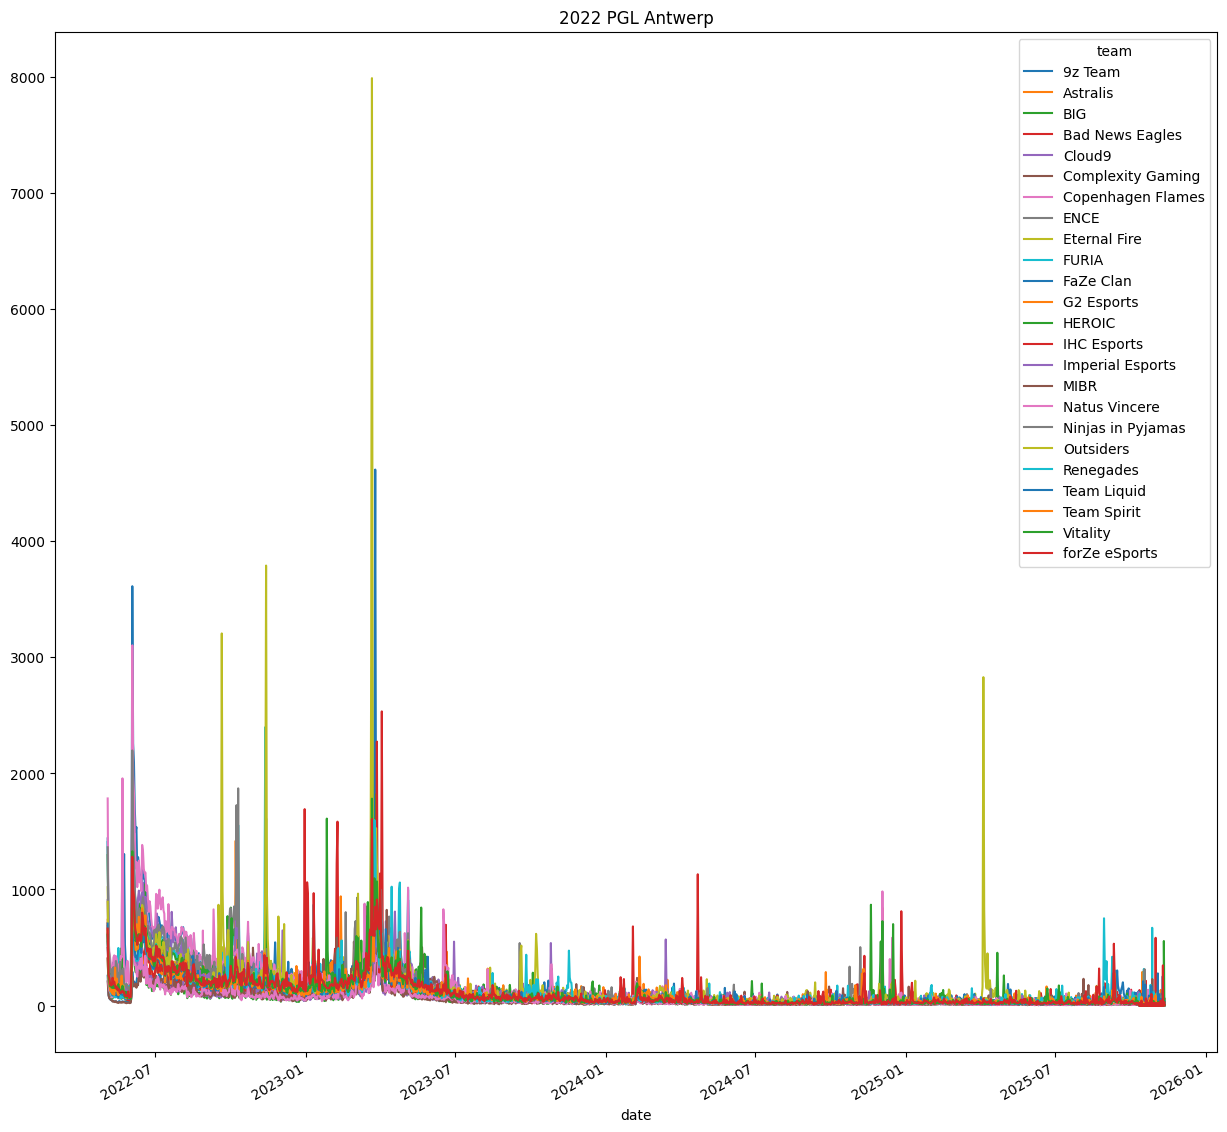

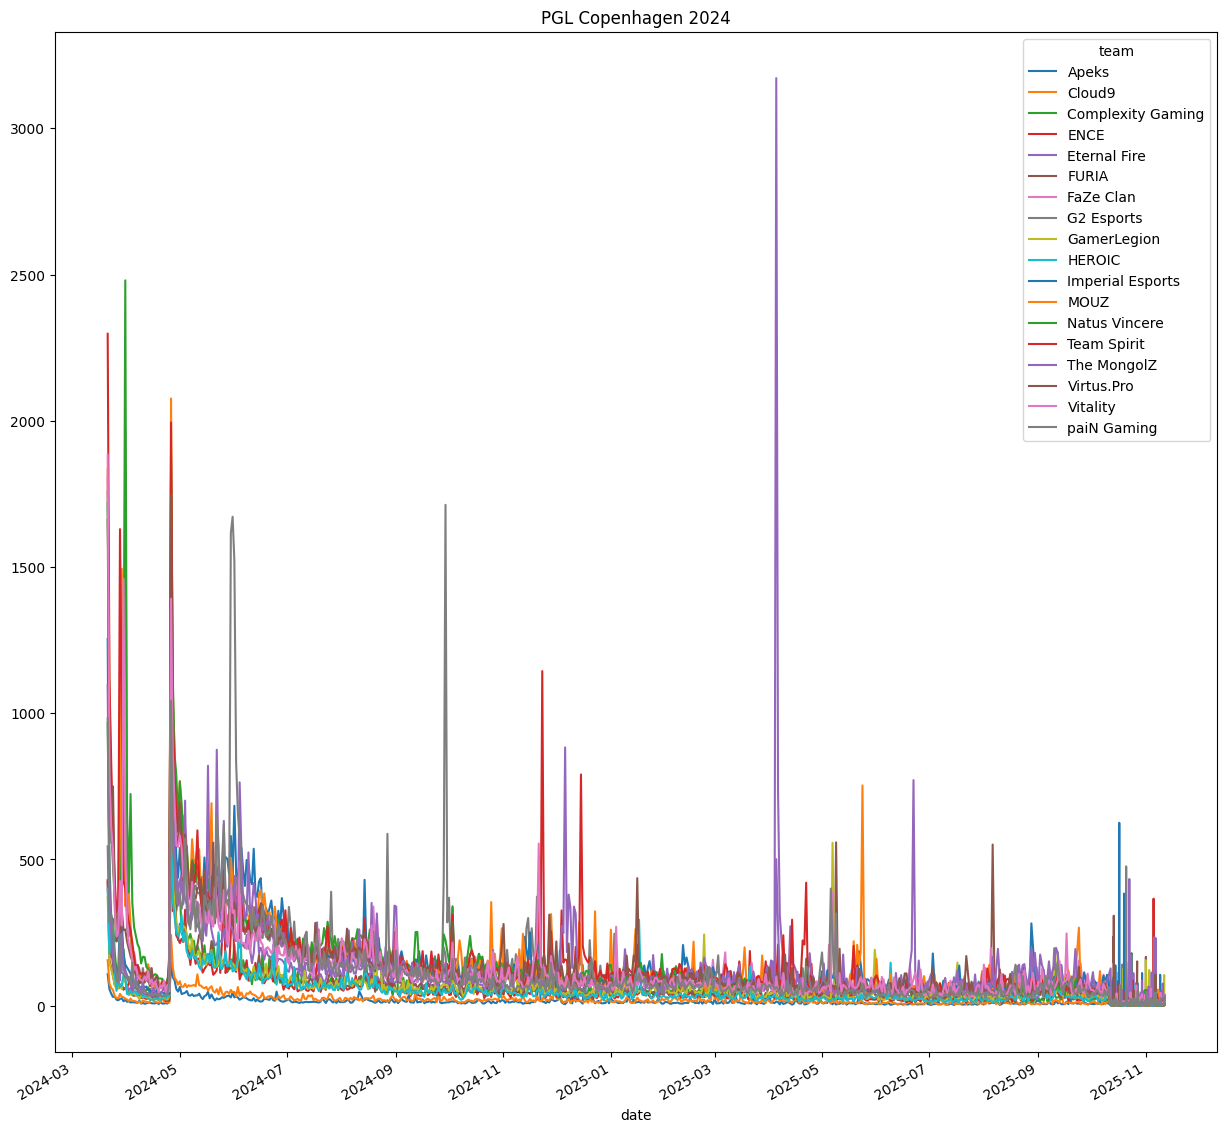

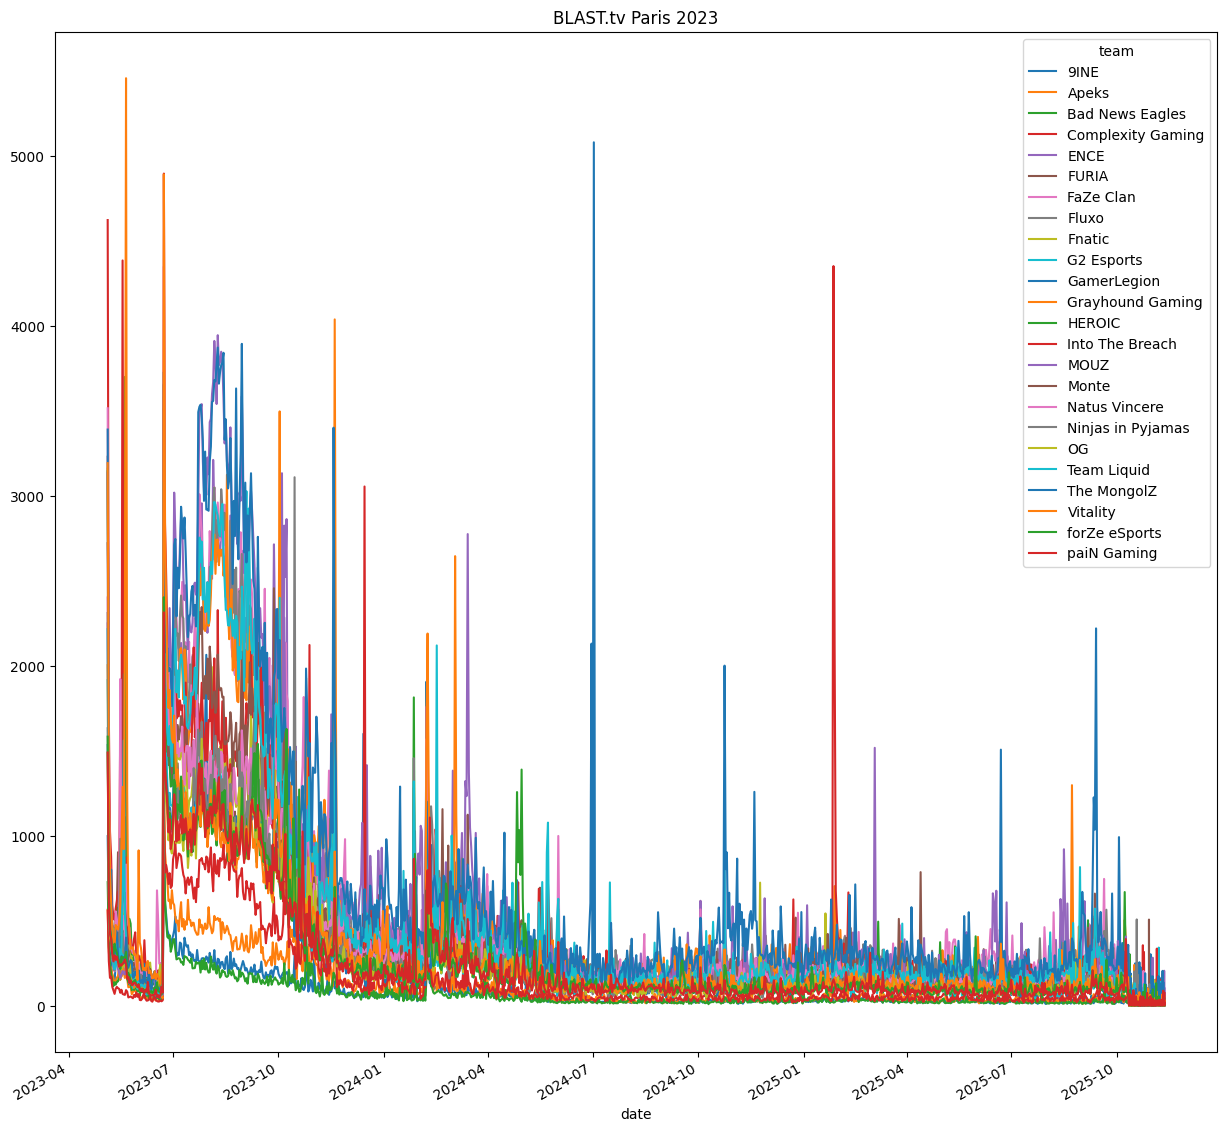

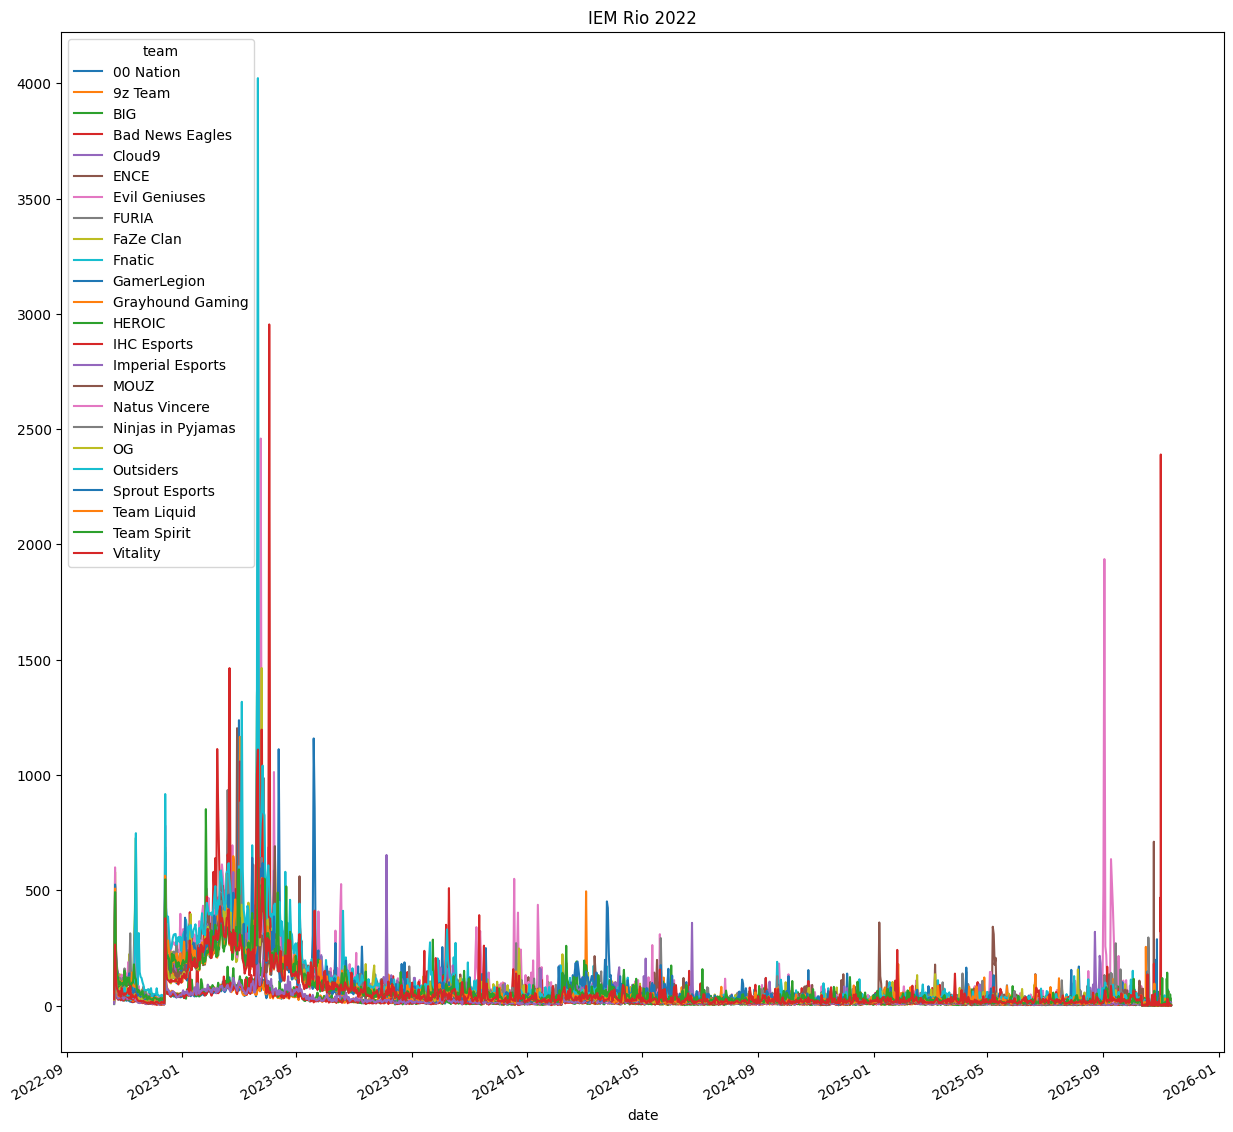

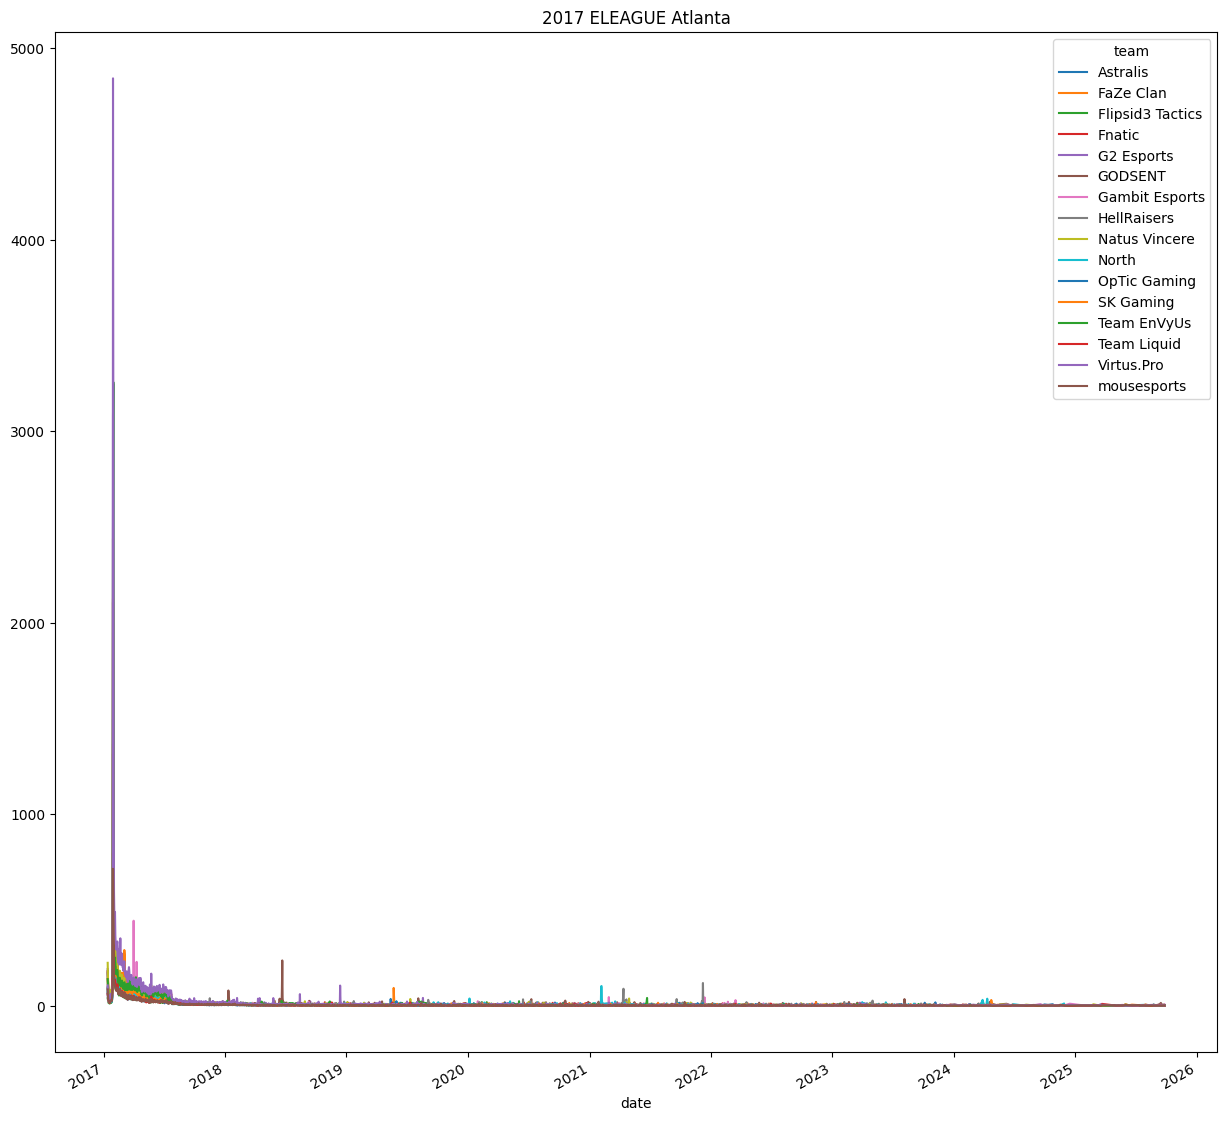

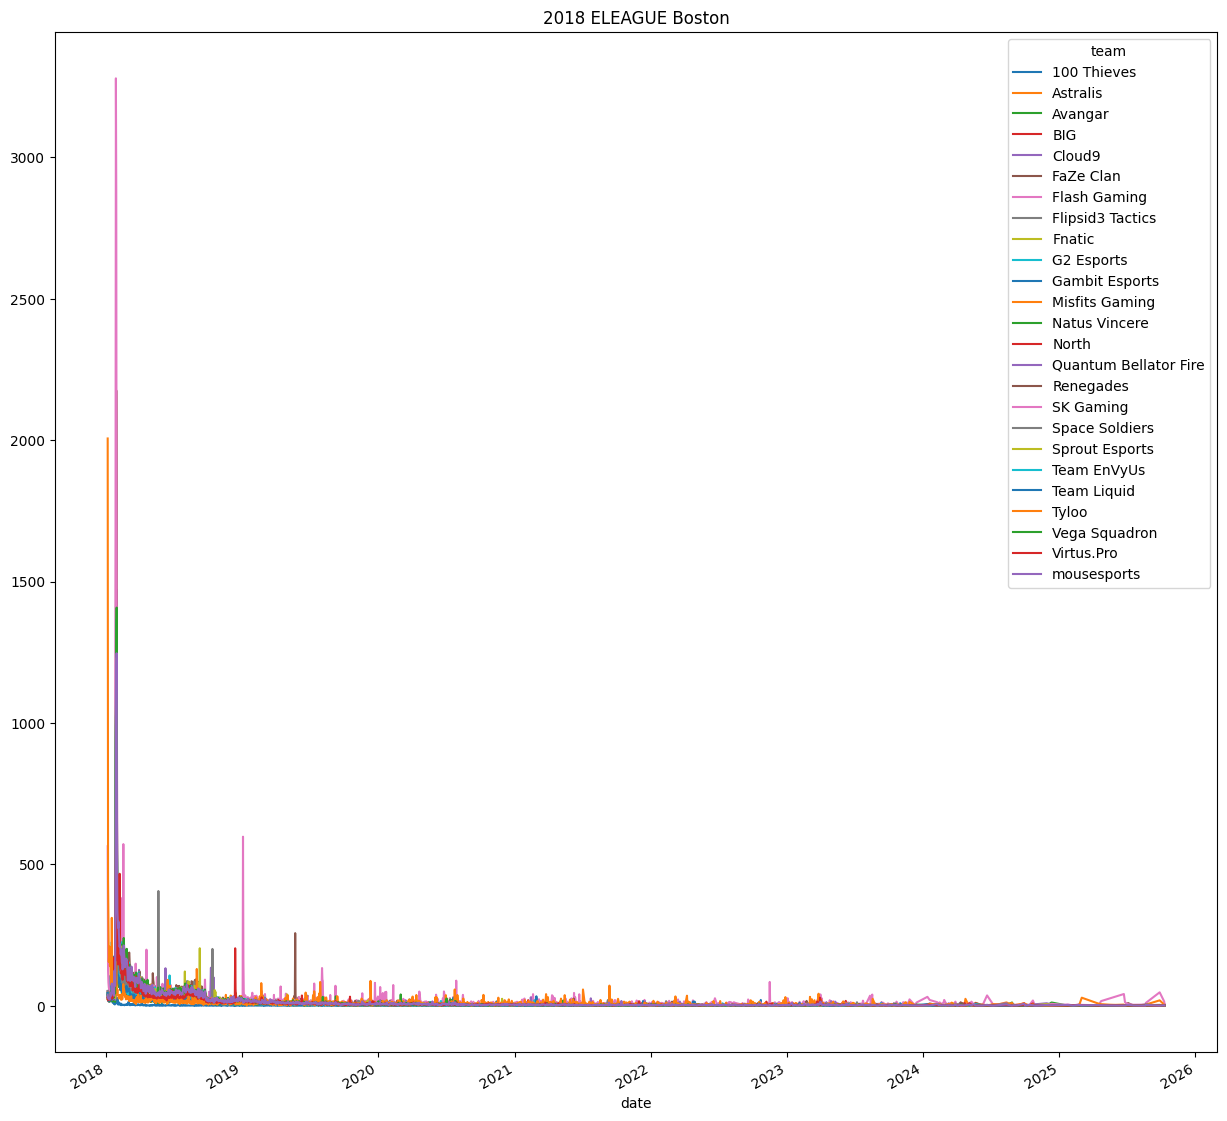

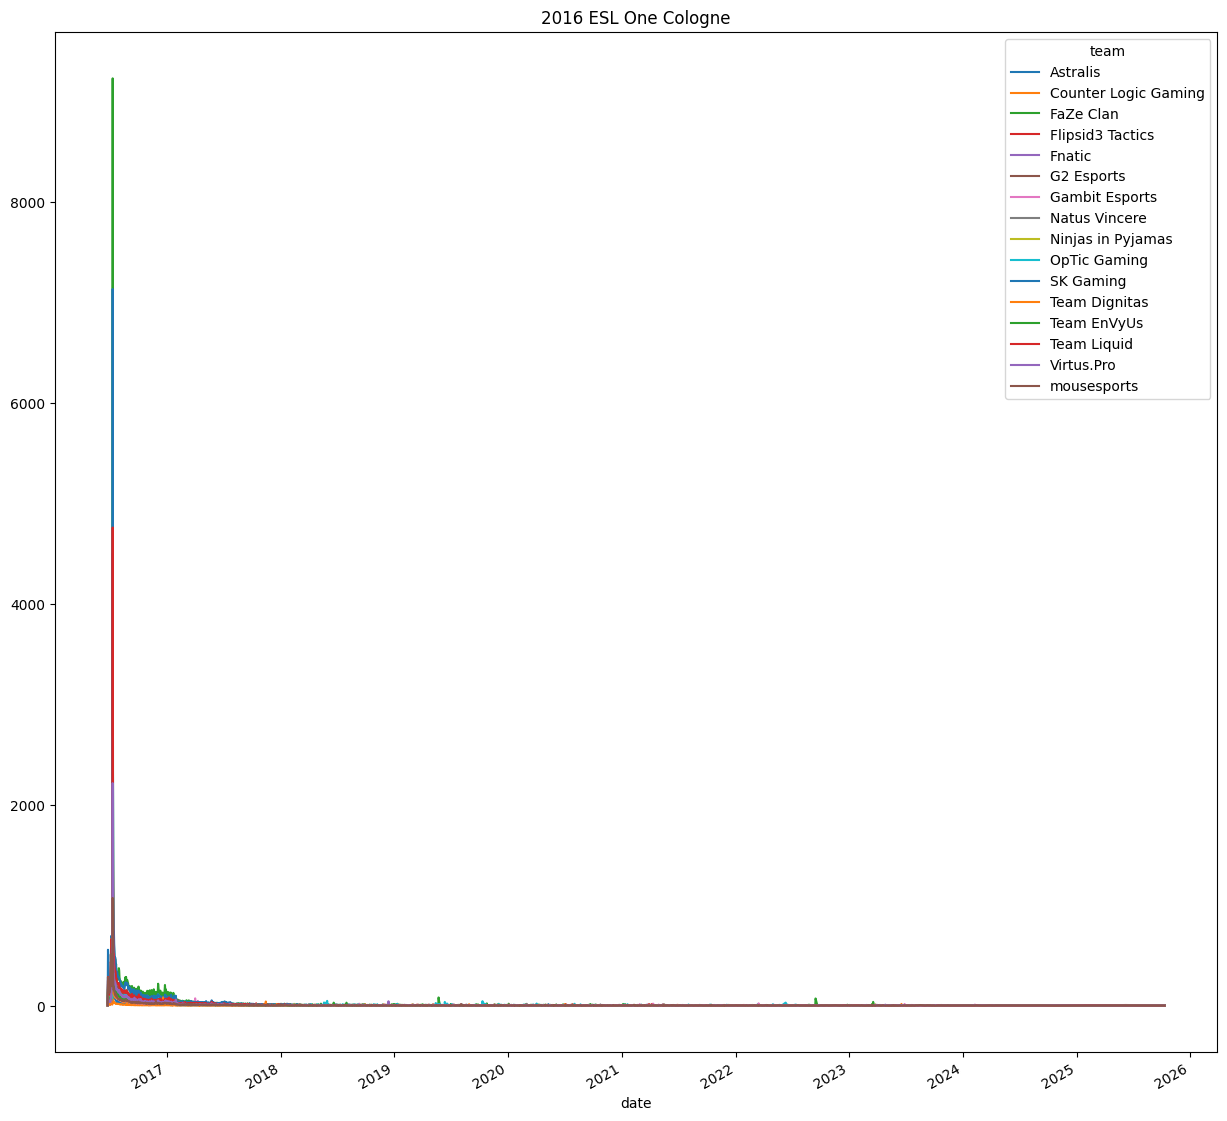

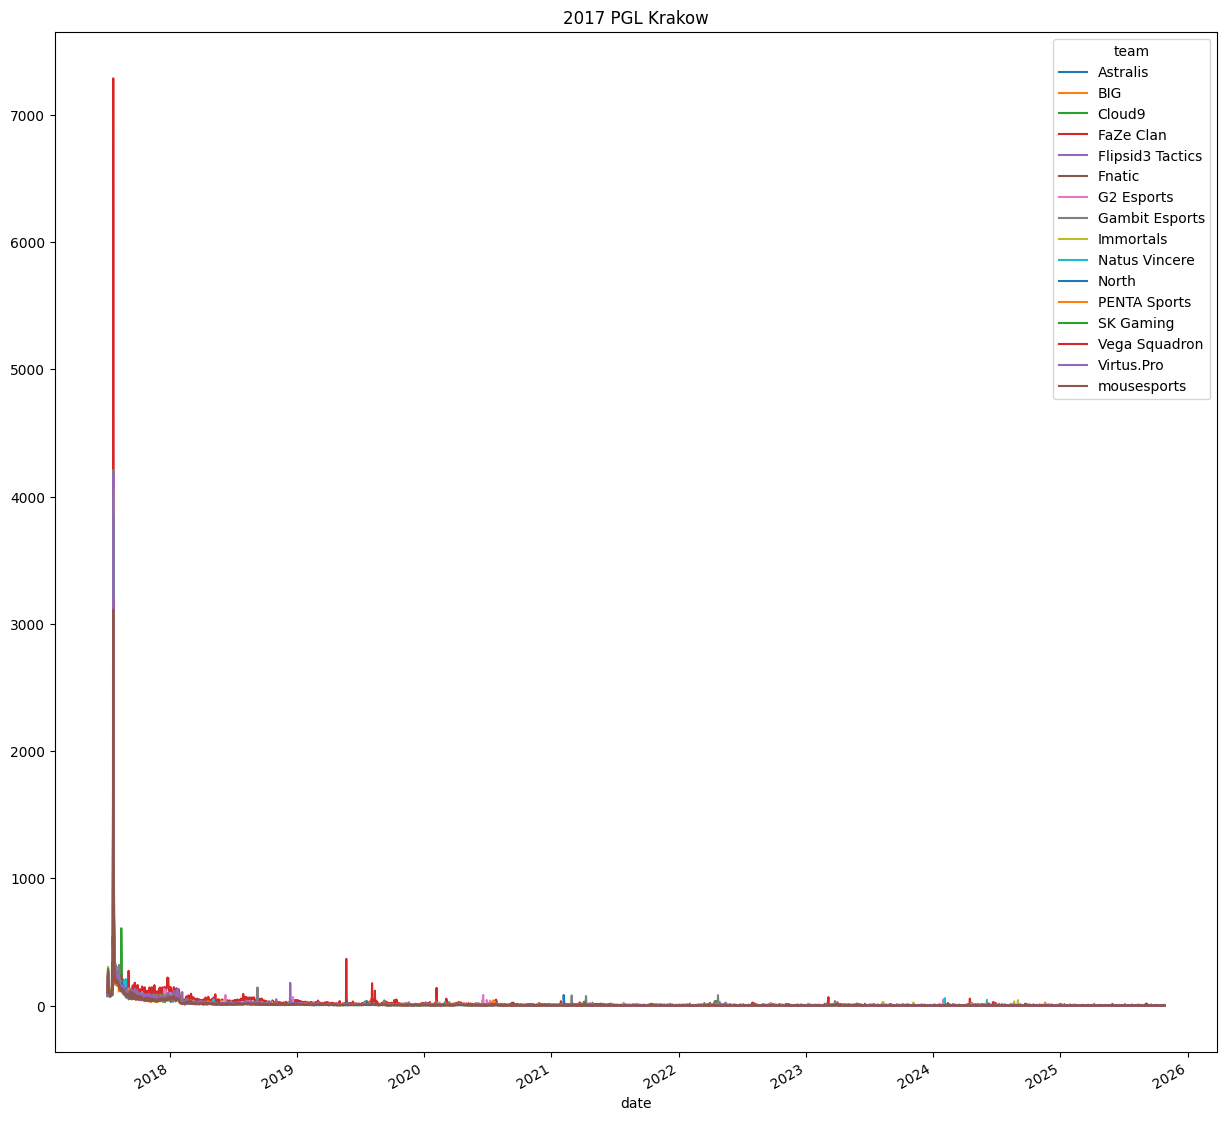

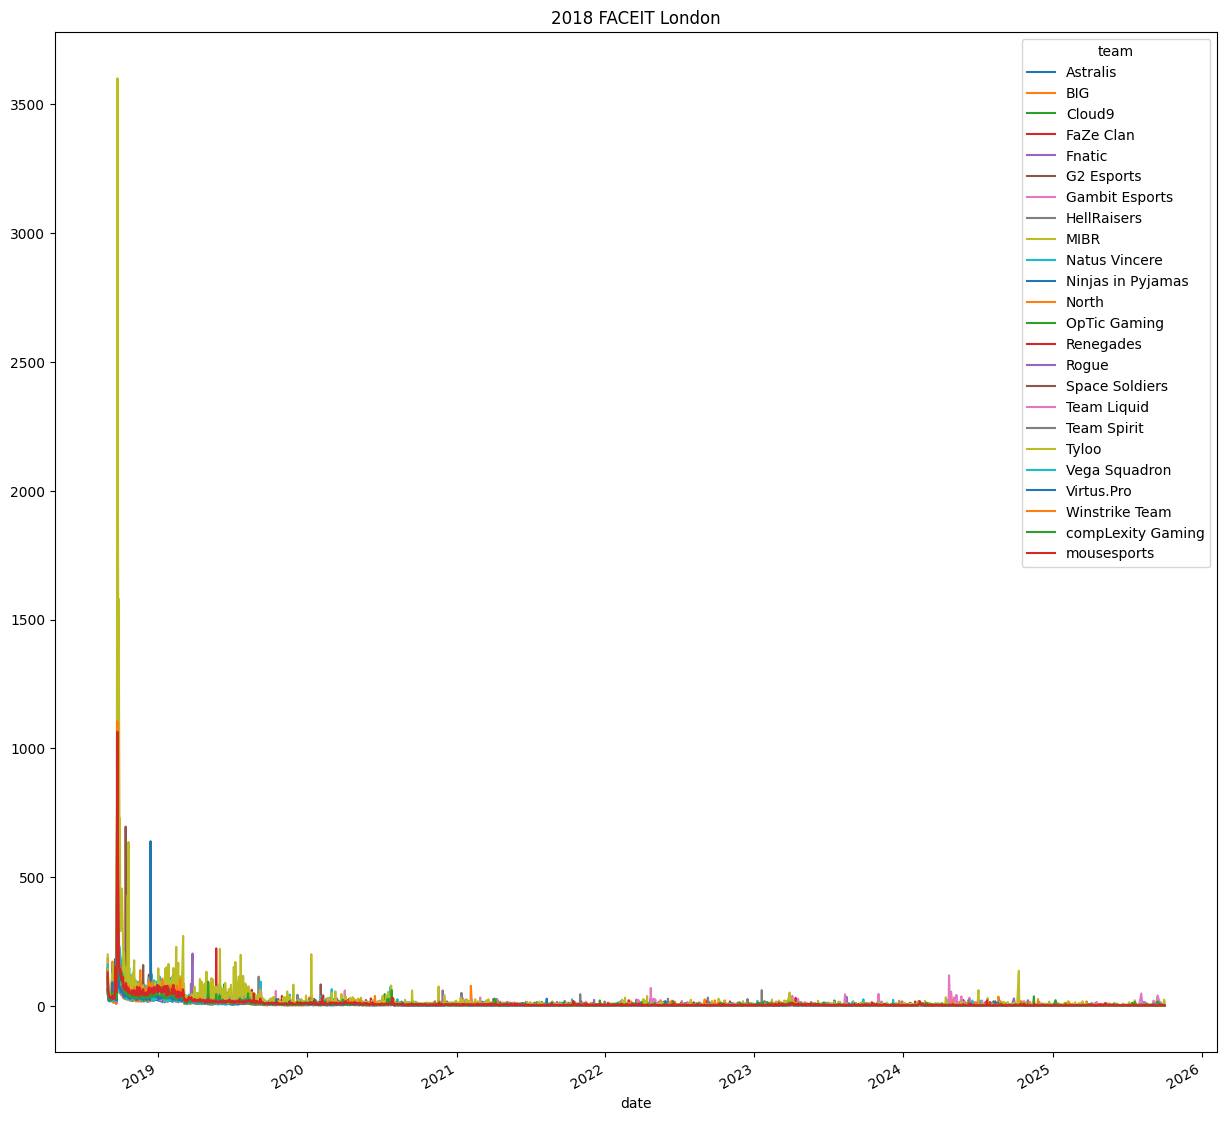

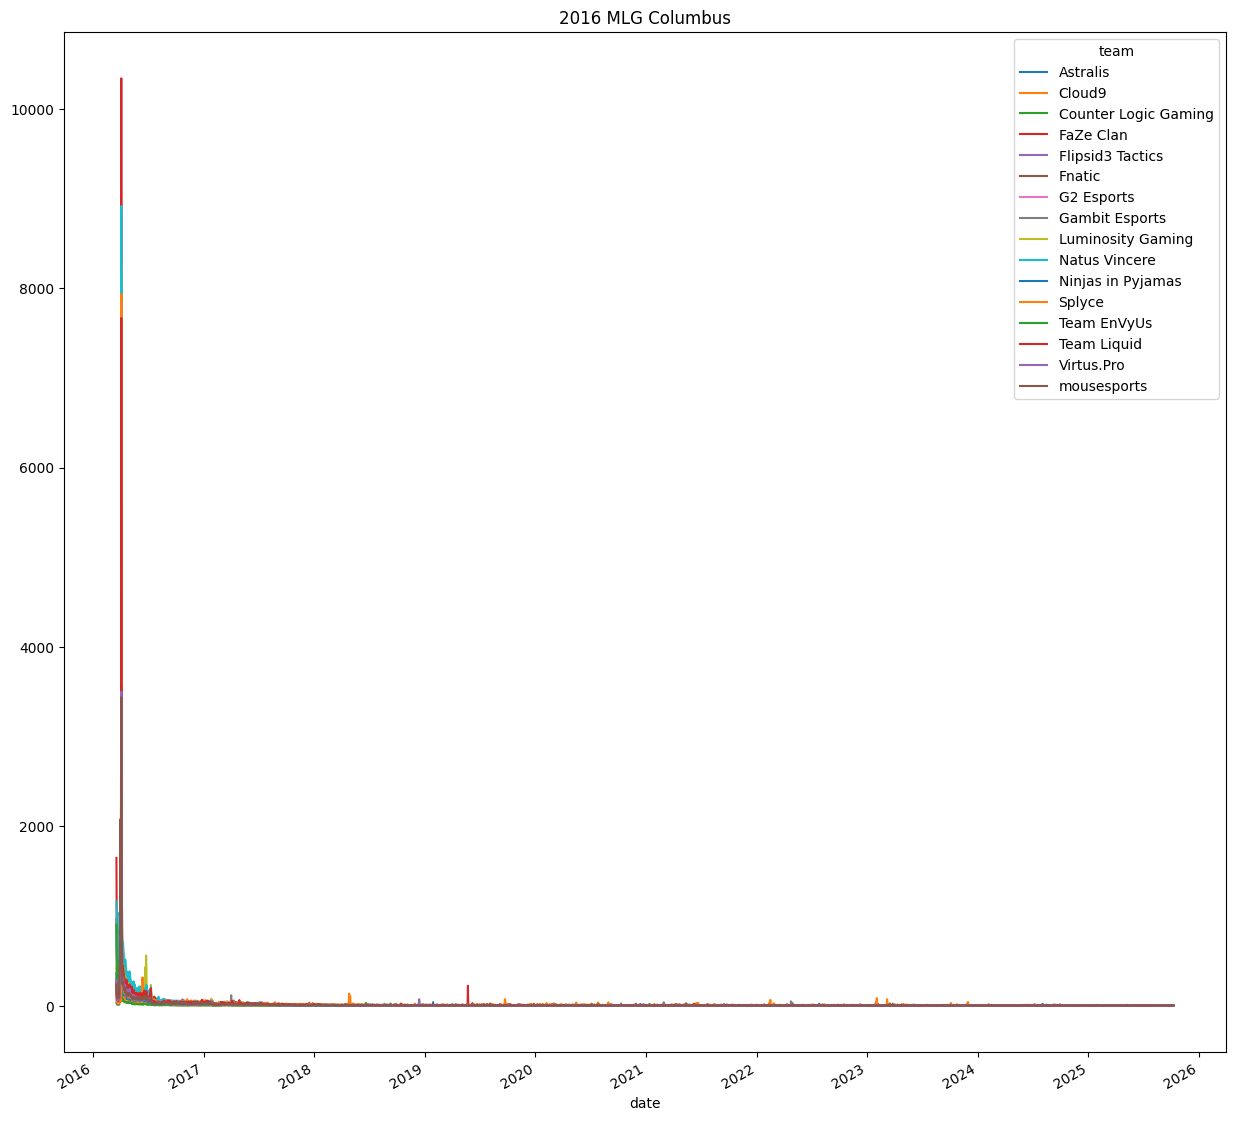

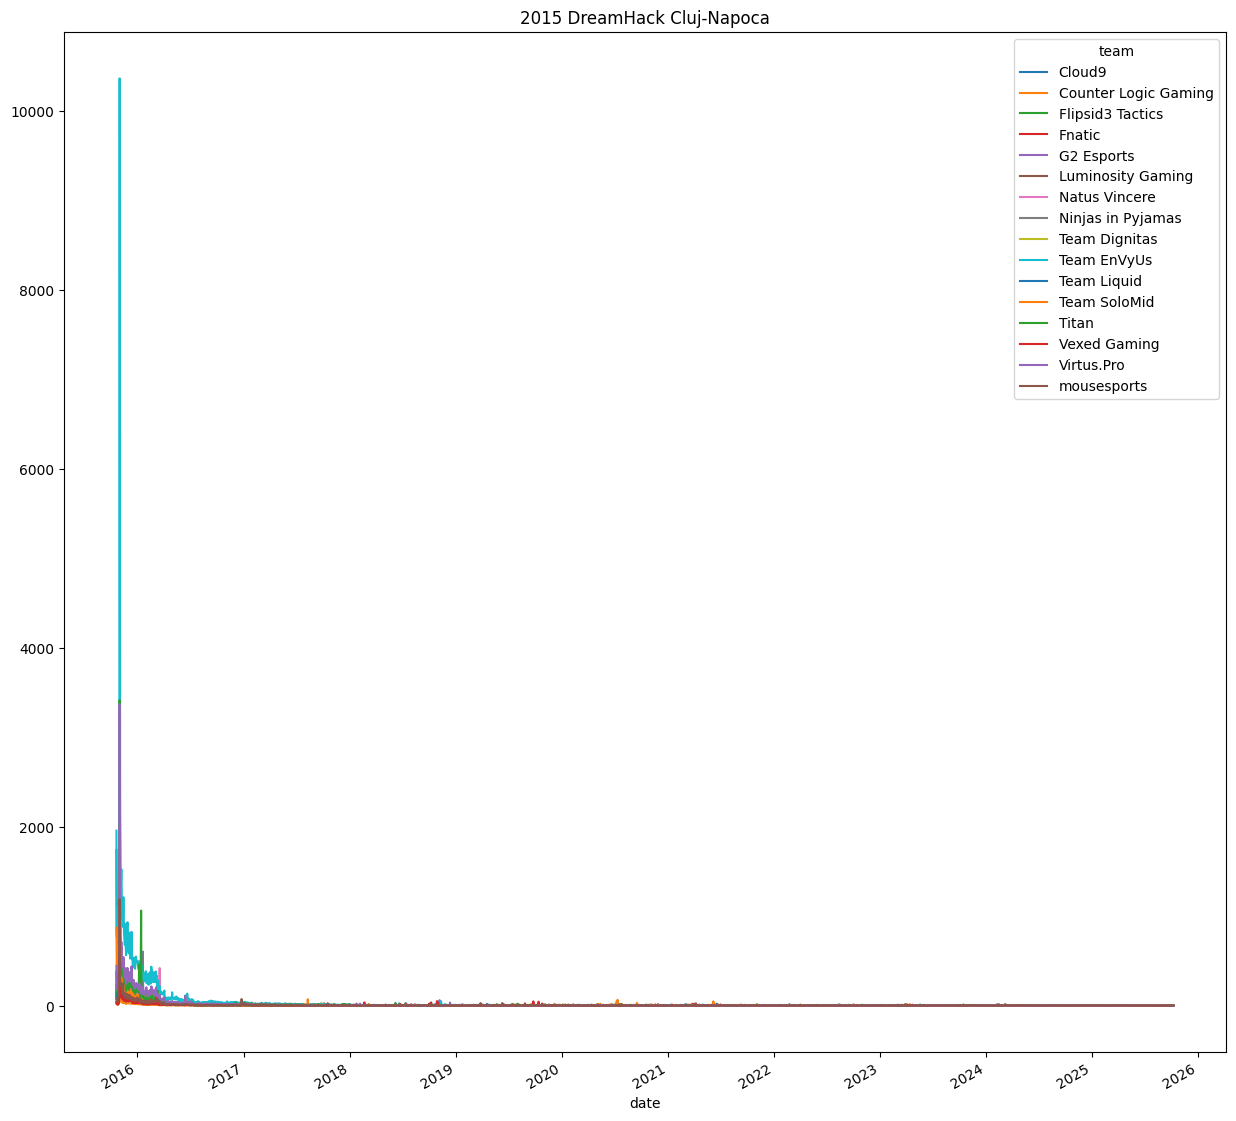

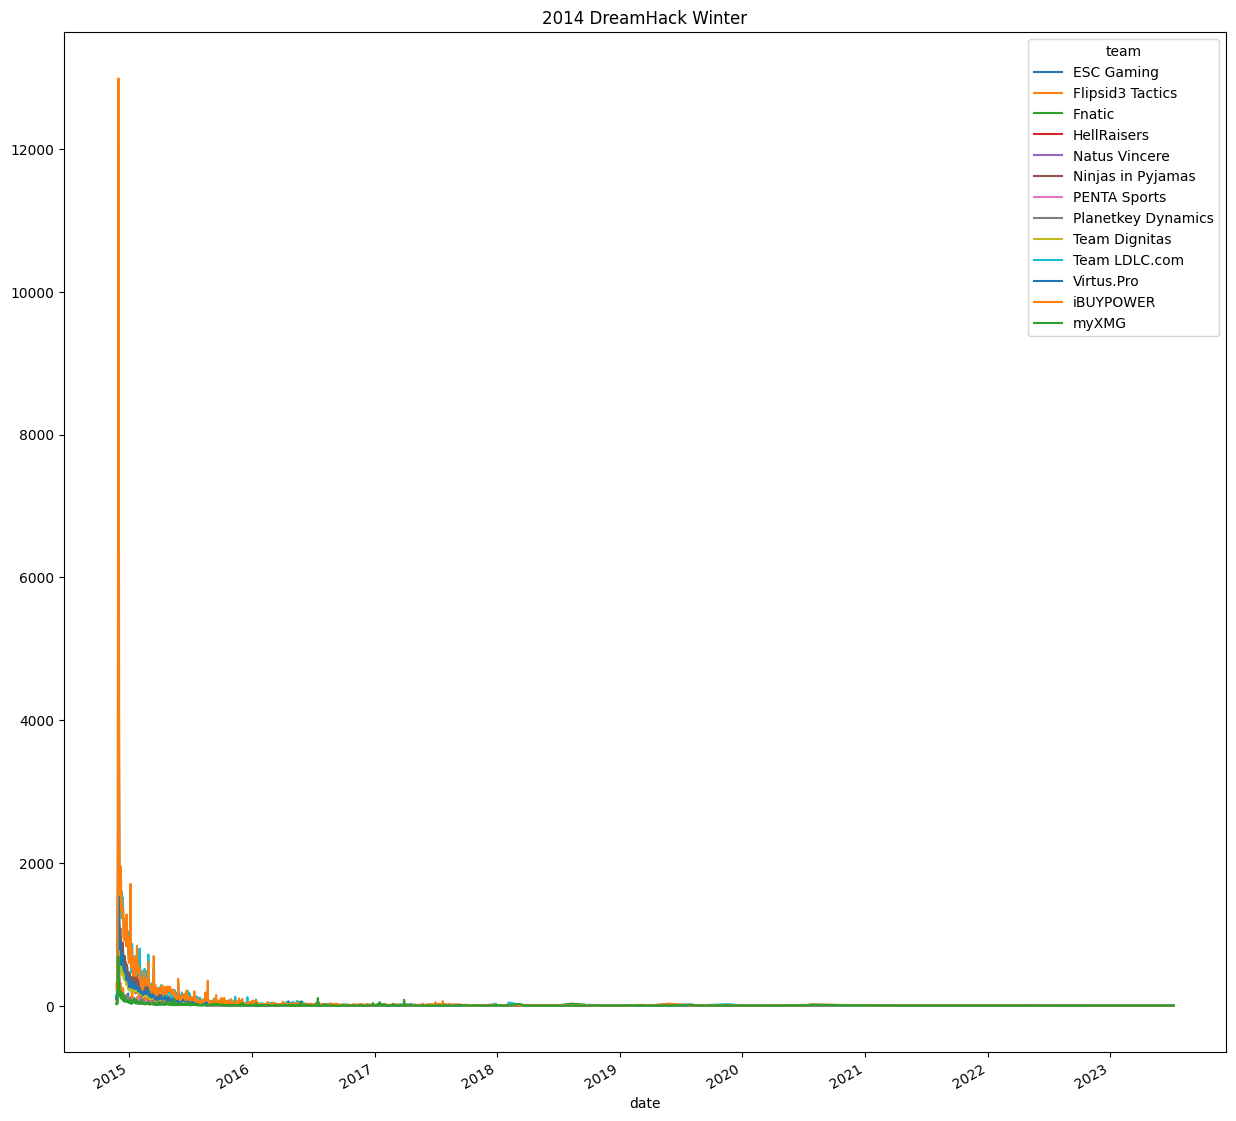

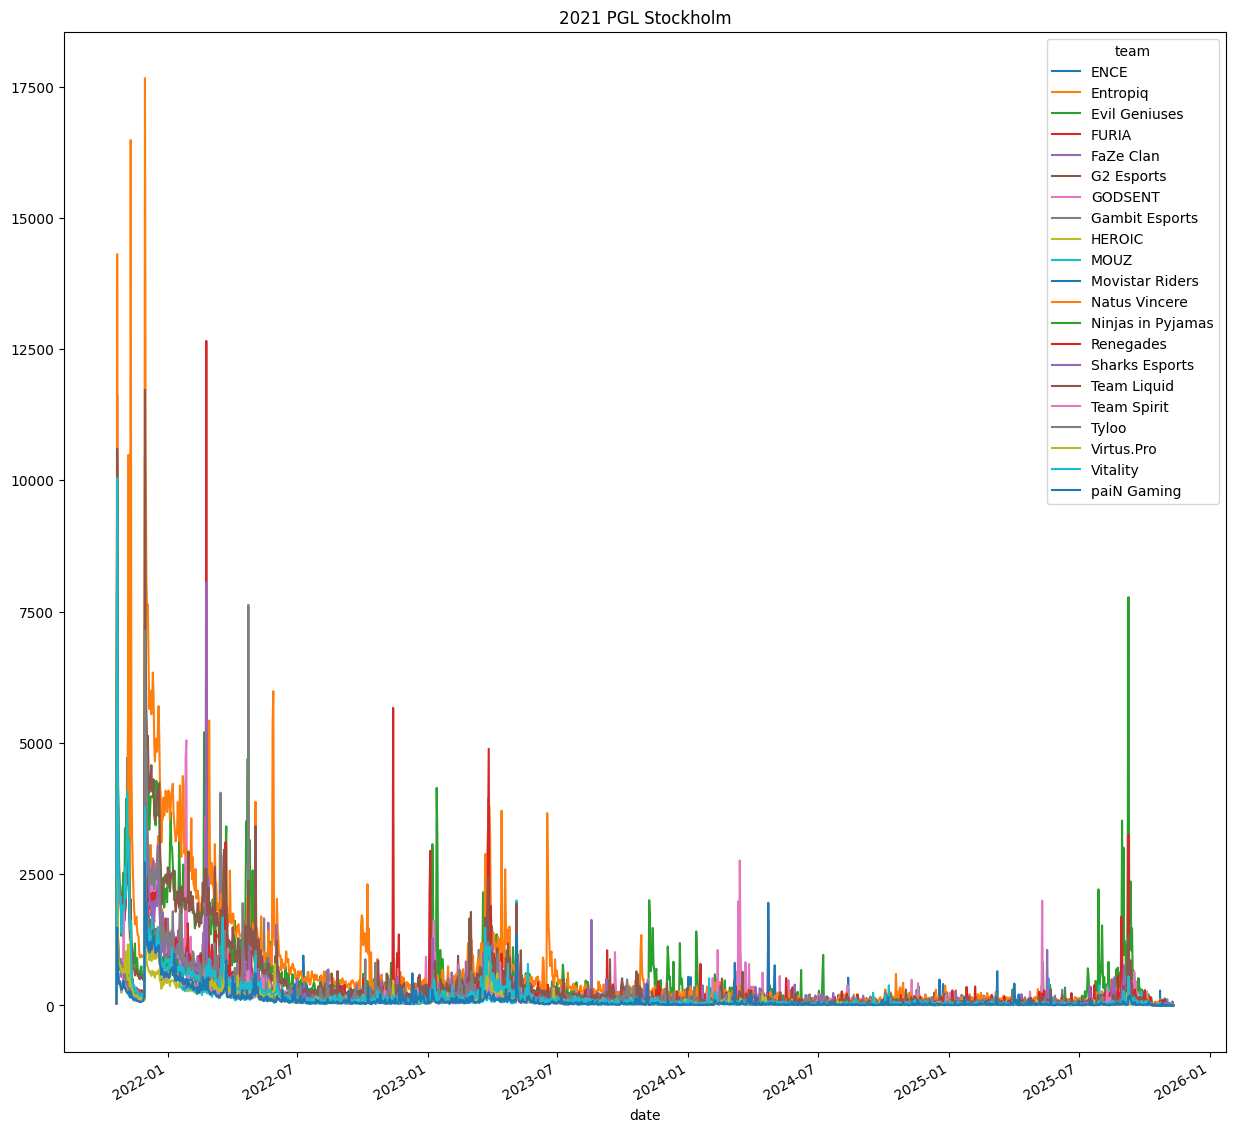

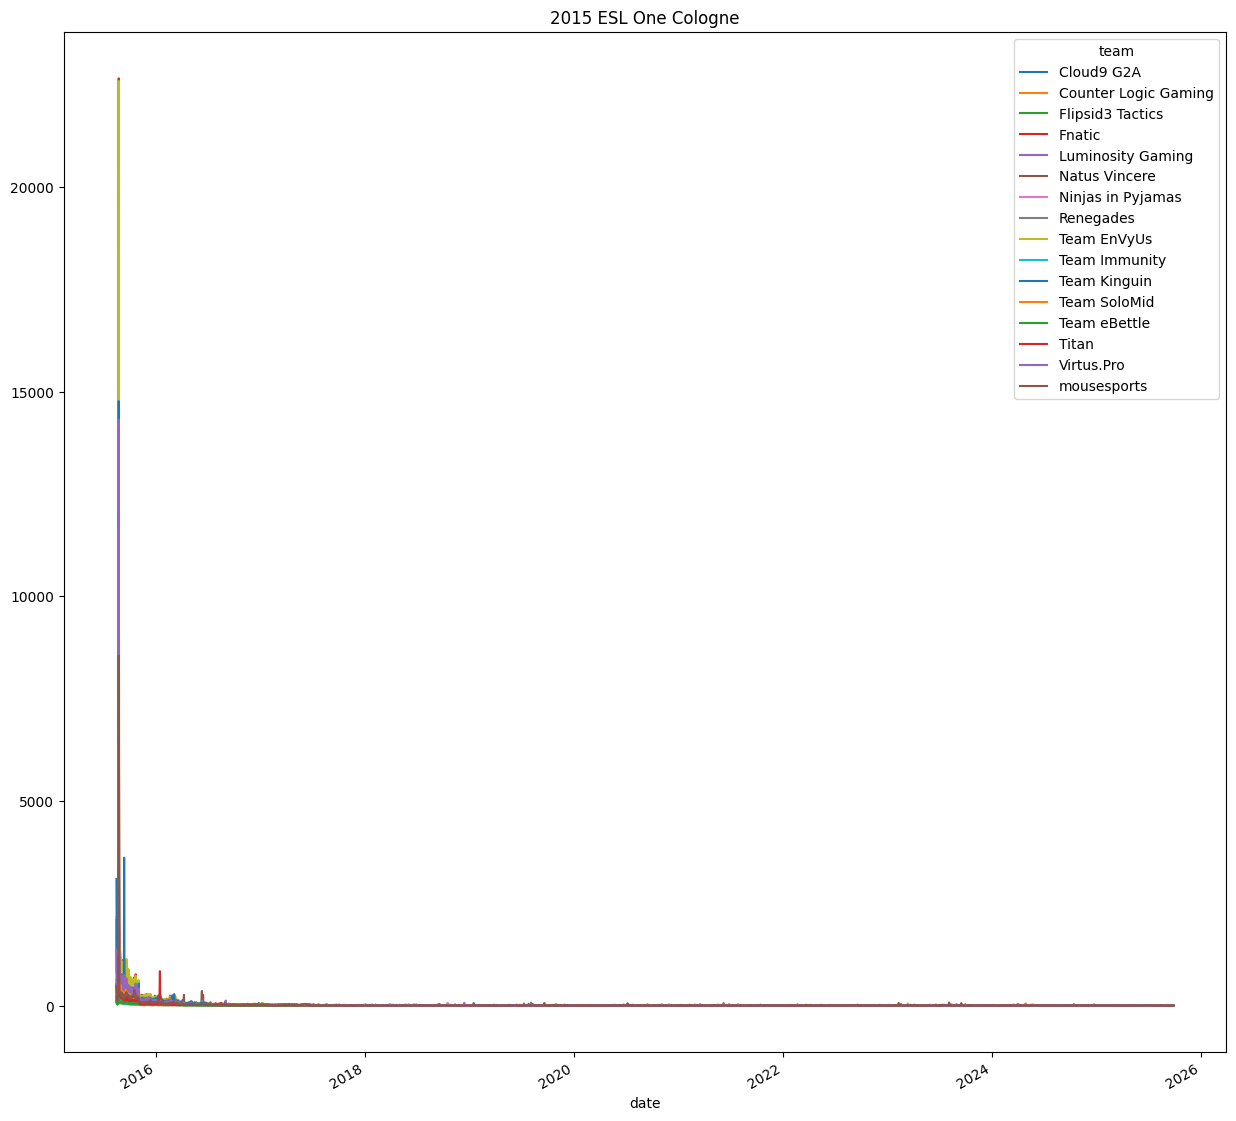

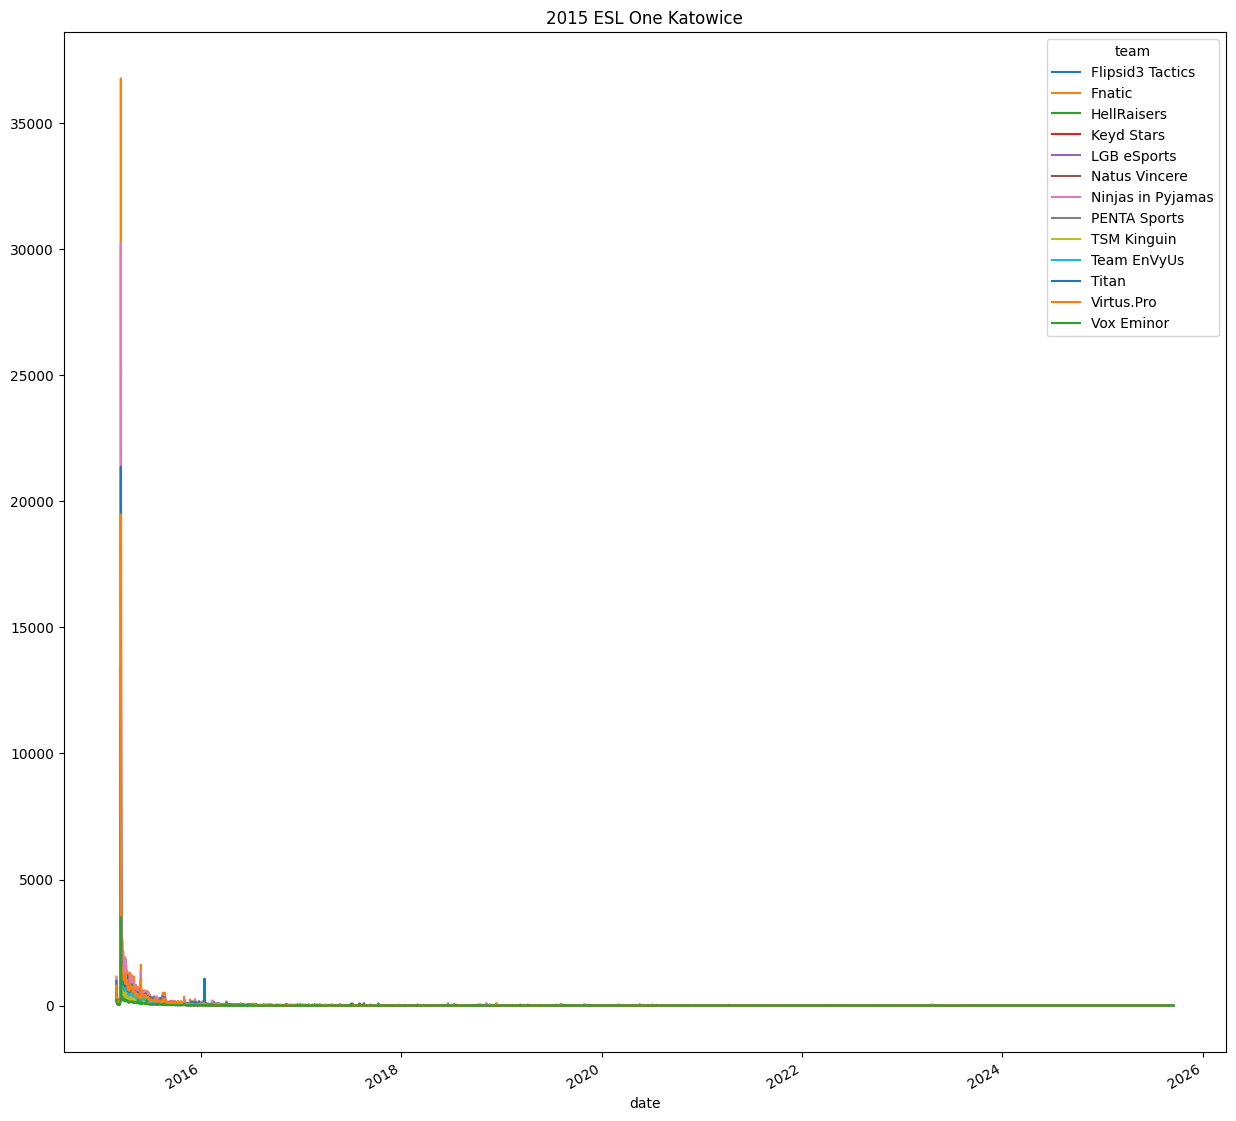

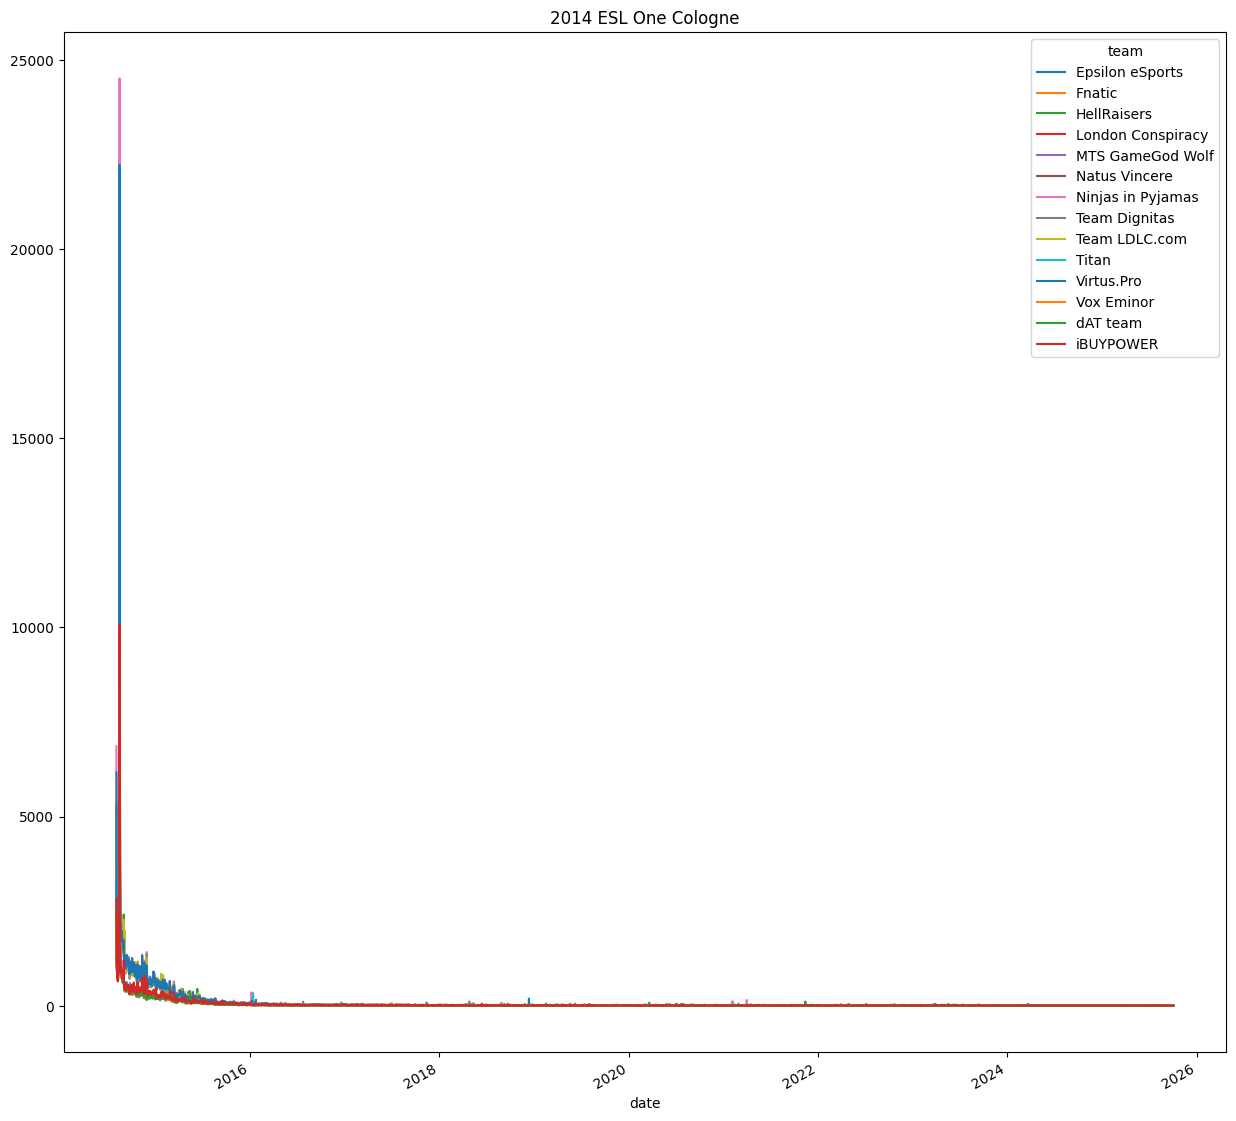

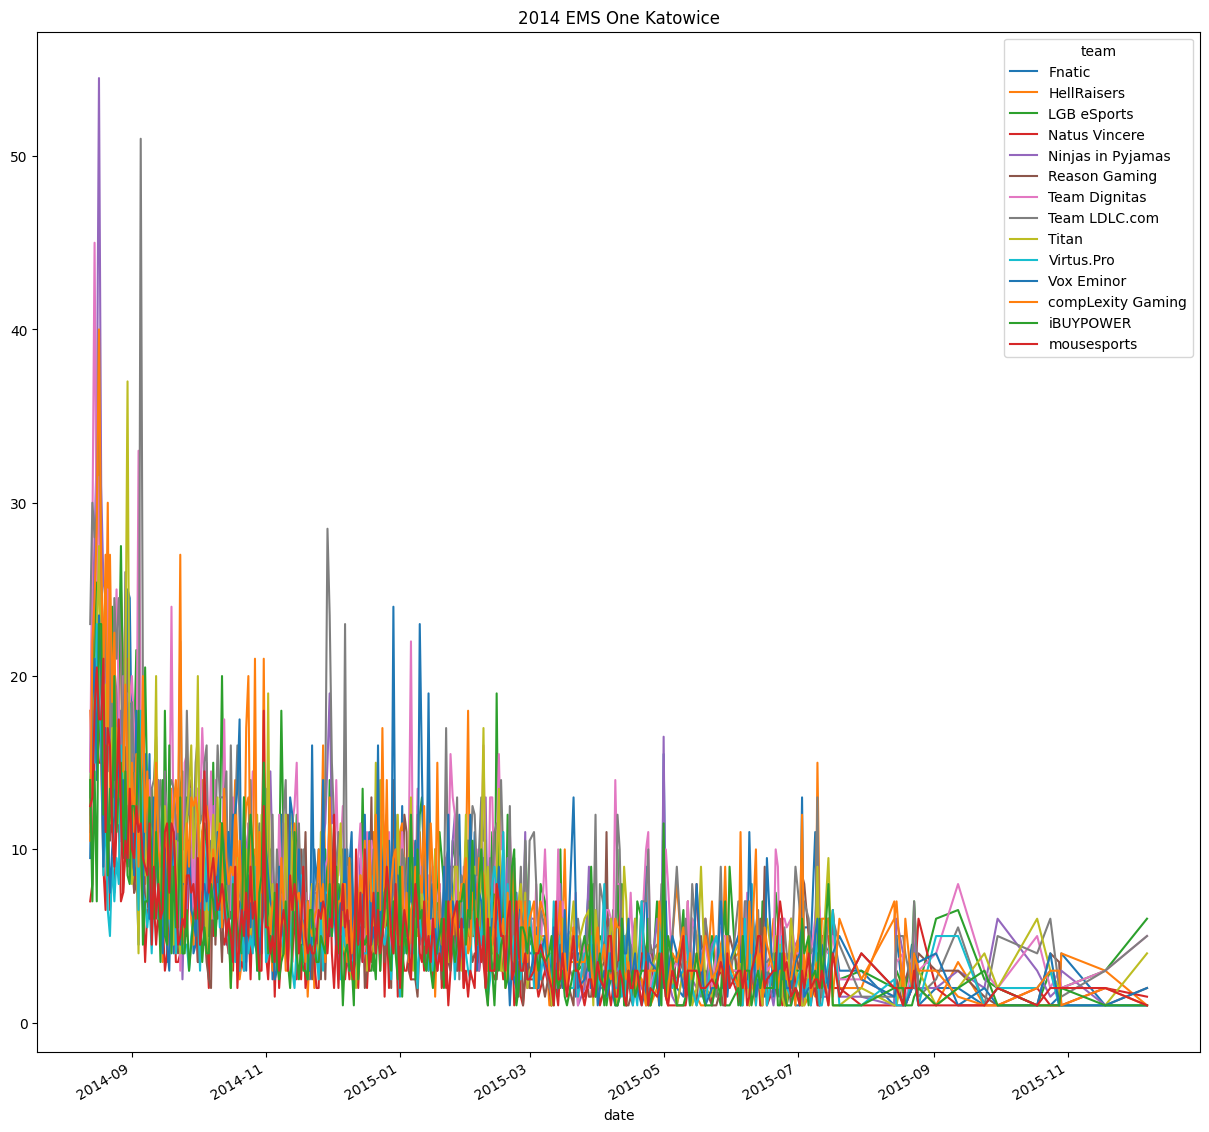

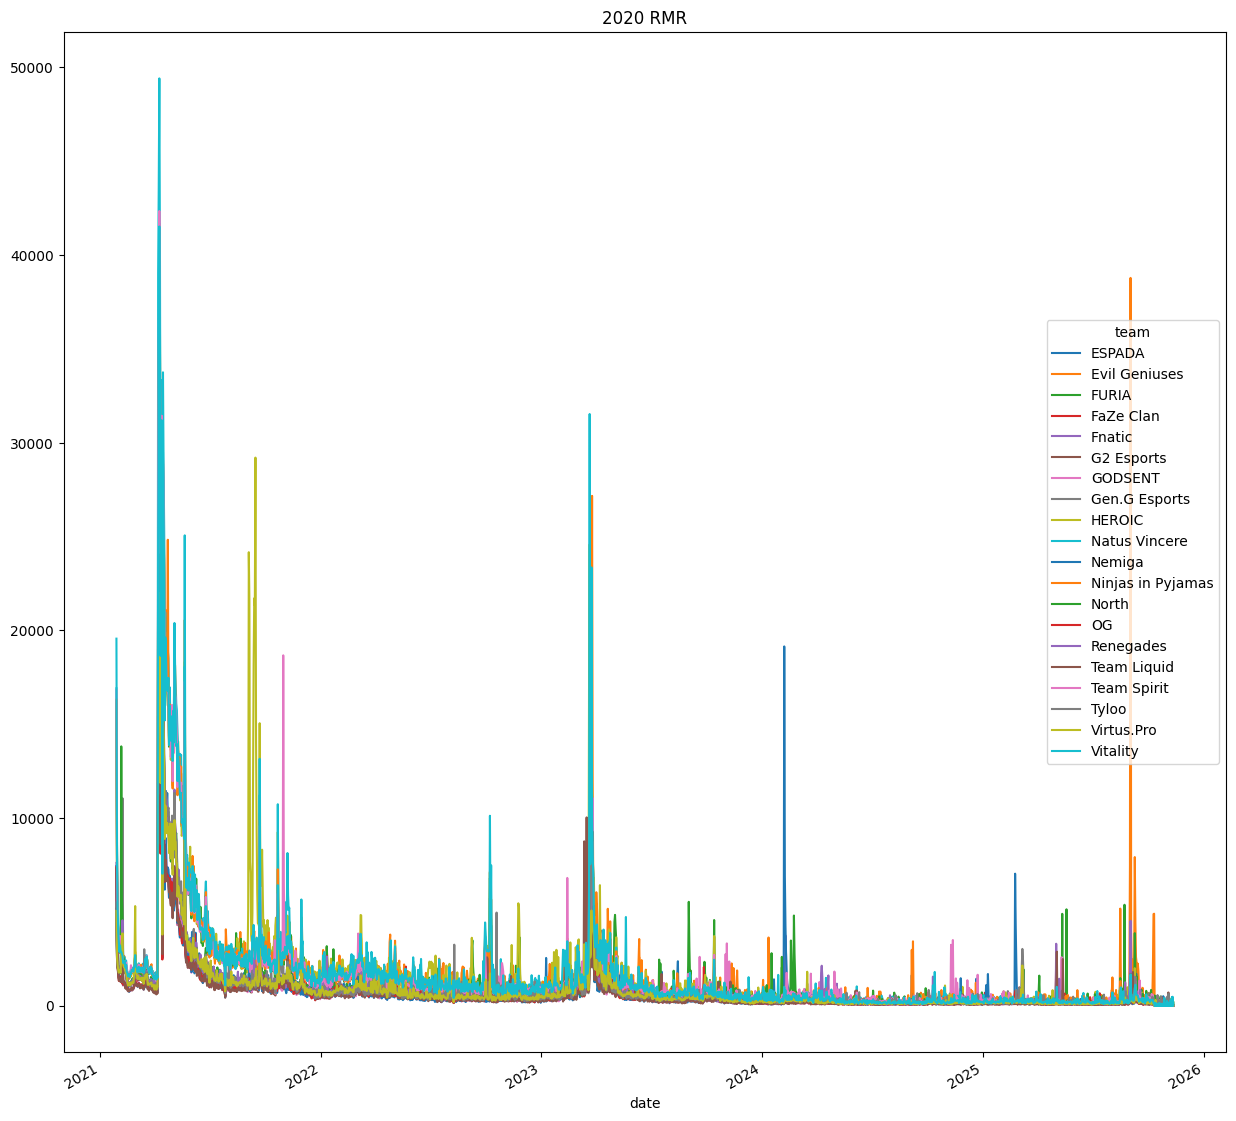

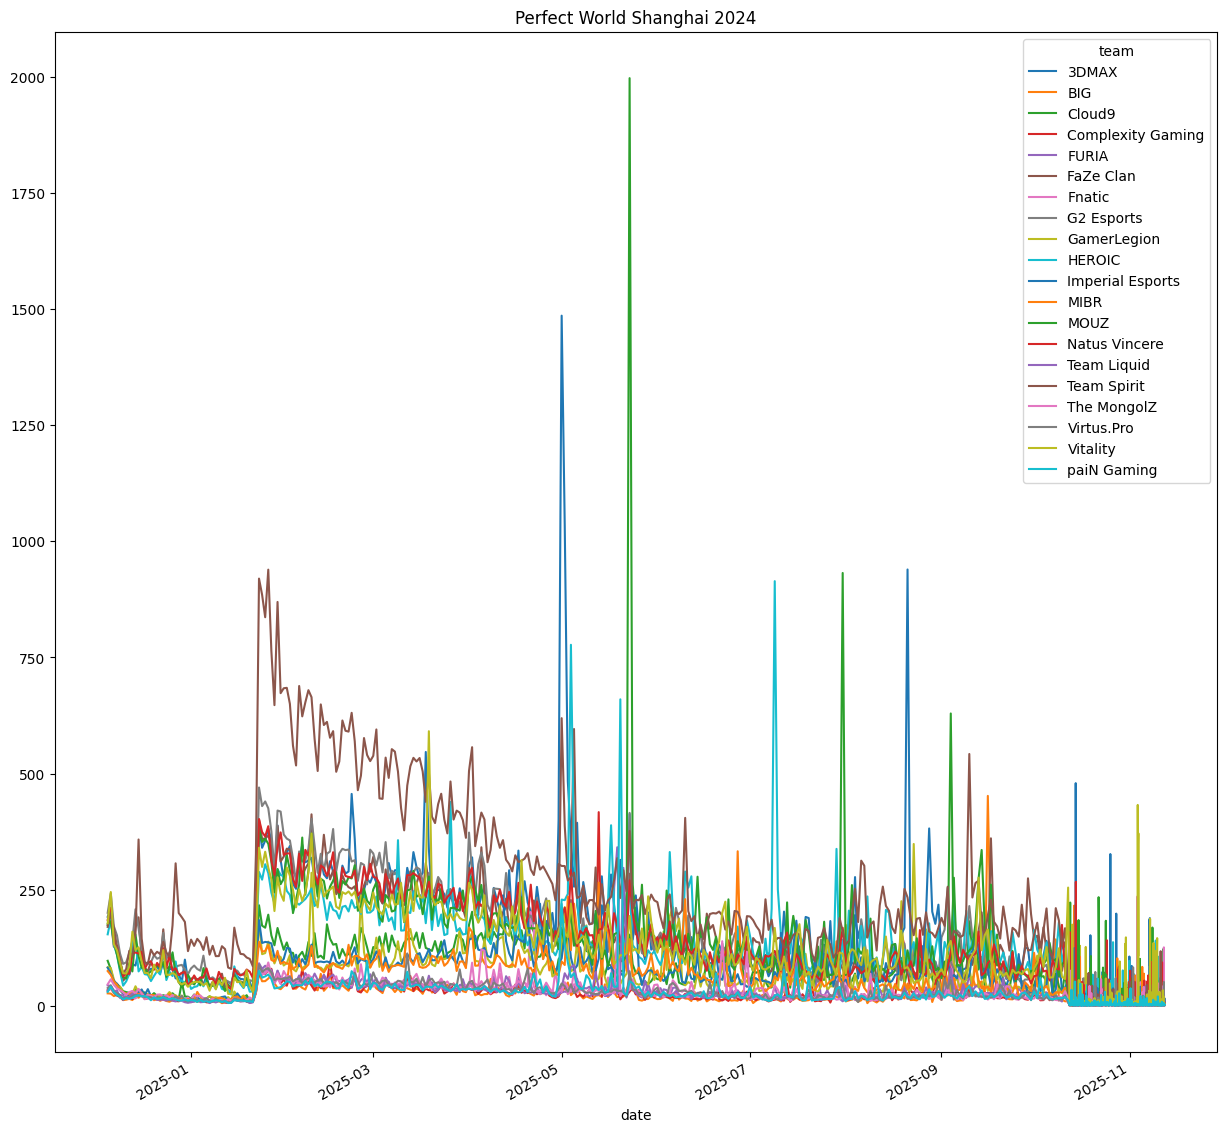

In [84]:
for x,y in duckdb.query("select tournament, tournament_id from stkr").df().drop_duplicates().values:
    if x is None:
        continue
    duckdb.query("select team, volume as money, date from stkr where tournament_id = "+ str(y) ).df().pivot_table(columns="team", values="money", index="date").dropna().reset_index().plot.line(
    x="date",
    title = x,
    figsize=(15,15)
)
    #+ " and ABS(DATEDIFF('day', '2019-09-05',date)) < 15"

In [77]:
duckdb.query("select team, volume as money, date from stkr where tournament_id = 16 and ABS(DATEDIFF('day', '2019-09-05',date)) < 15").df().pivot_table(columns="team", values="money", index="date").dropna().T.idxmax()

date
2019-08-22 01:00:00        Natus Vincere
2019-08-23 01:00:00                 MIBR
2019-08-24 01:00:00        Natus Vincere
2019-08-25 01:00:00                 MIBR
2019-08-26 01:00:00        Natus Vincere
2019-08-27 01:00:00             Astralis
2019-08-28 01:00:00                 MIBR
2019-08-29 01:00:00        Natus Vincere
2019-08-30 01:00:00    Ninjas in Pyjamas
2019-08-31 01:00:00                 MIBR
2019-09-01 01:00:00        Natus Vincere
2019-09-02 01:00:00                 MIBR
2019-09-03 01:00:00        Natus Vincere
2019-09-04 01:00:00        Natus Vincere
2019-09-05 01:00:00            Renegades
2019-09-06 01:00:00             Astralis
2019-09-07 01:00:00        Natus Vincere
2019-09-08 01:00:00        Natus Vincere
2019-09-09 01:00:00        Natus Vincere
2019-09-10 01:00:00        Natus Vincere
2019-09-11 01:00:00        Natus Vincere
2019-09-12 01:00:00        Natus Vincere
2019-09-13 01:00:00        Natus Vincere
2019-09-14 01:00:00              Avangar
2019-09-15 